# Projet de MAP568

### Modèle de Lotka-Volterra

Question 1.

In [1]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def system(t, Y, A, m=0):
    """
    Differential equation system representing a biological model.

    Parameters:
    - t: Time variable (not used in this function, included for compatibility with solvers).
    - Y: List containing the state variables [x, y].
    - A: List containing model parameters [A0, A1, A2, A3, A4, A5].
    - m: Exponent parameter (default is 0).

    Output:
    - List containing the derivatives [dx_dt, dy_dt] of the state variables with respect to time.
    """

    # Unpack state variables
    y1, y2 = Y

    # Calculate intermediate variable B for better lisibility
    B = A[2] * y1 * y2**(-m) / (1 + A[2] * A[3] * y1 * y2**(-m))

    # Calculate derivatives of state variables
    dy1_dt = A[0] * (1 - A[1] * y1) * y1 - B * y2
    dy2_dt = A[4] * B * y2 - A[5] * y2

    # Return the derivatives as a list
    return [dy1_dt, dy2_dt]


In [3]:
def solution(t0, tf, y1_0, y2_0, A, n_step=17, m=0):
    """
    Numerically solves a system of ordinary differential equations.

    Parameters:
    - t0: Initial time.
    - tf: Final time.
    - x0: Initial value for the state variable x.
    - y0: Initial value for the state variable y.
    - A: List containing model parameters [A0, A1, A2, A3, A4, A5].
    - n_step: Number of steps for the numerical integration (default is 17).
    - m: Exponent parameter (default is 0).

    Output:
    - Solution object containing the results of the numerical integration.
    """

    # Define the time points where the solution will be evaluated
    t_eval_points = np.linspace(t0, tf, n_step)

    # Use the solve_ivp function to numerically integrate the system of ODEs
    solution = solve_ivp(system, [t0, tf], [y1_0, y2_0], method='RK45', args=(A, m), t_eval=t_eval_points)

    # Return the solution object
    return solution


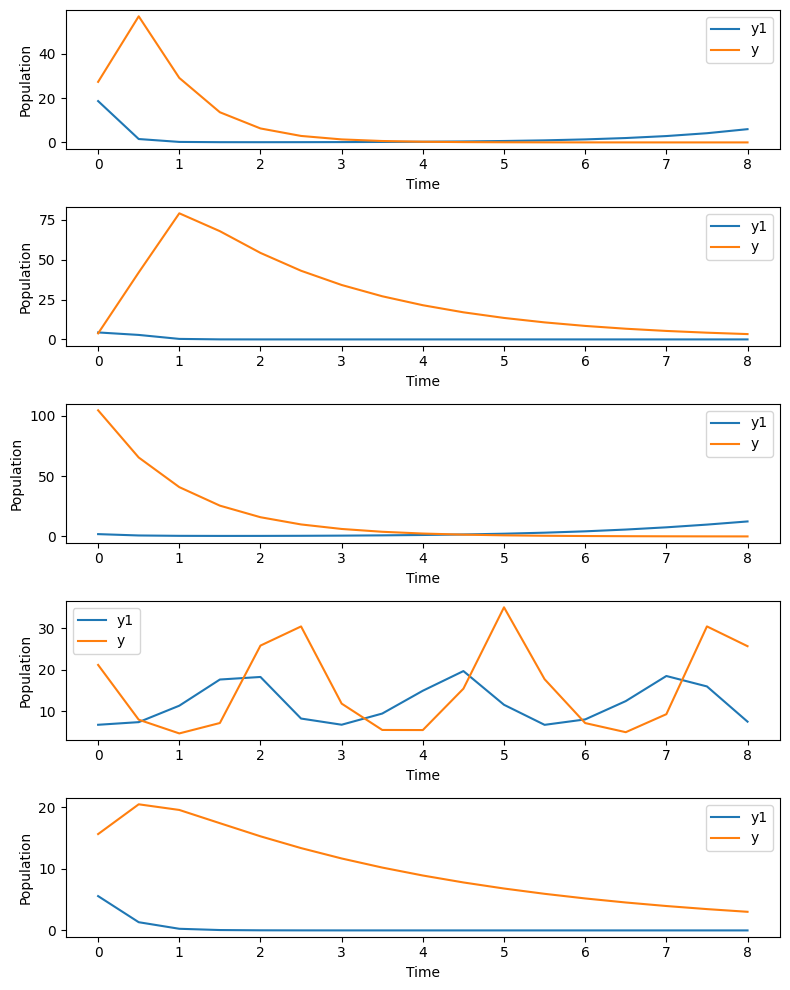

In [4]:
# Define the prior distribution parameters
params = {
    'lambda': [1, 0.01, 0.1, 0.1, 1, 1, 10, 10],
    'zeta': 0.5 * np.log(10)
}

# Sample from the prior distribution
num_samples = 5
samples = []
for _ in range(num_samples):
    x = np.random.lognormal(np.log(params['lambda']), params['zeta'])
    samples.append((x[:6], x[6:]))

# Create subplots
fig, axs = plt.subplots(num_samples, 1, figsize=(8, 2*num_samples))

# Solve the system of differential equations for each sampled parameter set
for i, (a, y0) in enumerate(samples):
    Y = solution(0, 8, y0[0], y0[1], a)
    t = Y.t
    axs[i].plot(t, Y.y[0], label='y1')
    axs[i].plot(t, Y.y[1], label='y')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Population')
    axs[i].legend()

plt.tight_layout()
plt.show()


Question 2.

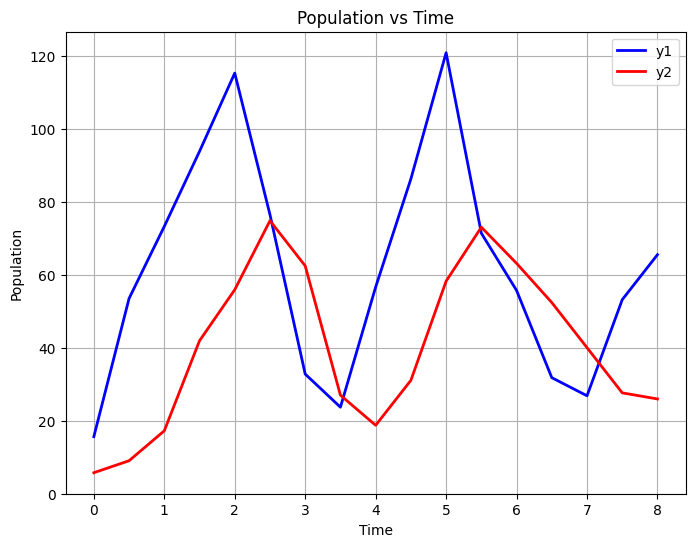

In [5]:
# Initialize lists to store data
t = []
y1 = []
y2 = []

# Read data from the file
with open("data_veil_11a.txt", 'r') as file:
    for line in file:
        # Split the line into columns and convert them to floats
        values = [float(value) for value in line.split()]
        if values == []:
            break
        # Append the values to their respective lists
        t.append(values[0])
        y1.append(values[1])
        y2.append(values[2])

data_proie = y1
data_predateur = y2

# Customize the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size
plt.plot(t, y1, label='y1', color='blue', linewidth=2)  # Change line color and width
plt.plot(t, y2, label='y2', color='red', linewidth=2)  # Change line color and width
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population vs Time')  # Add a title
plt.grid(True)  # Add grid lines
plt.legend()
plt.show()

Question 3.

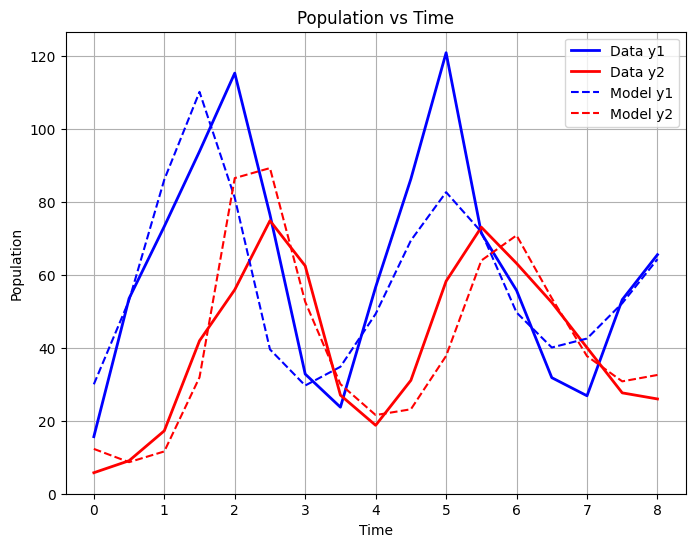

In [6]:
# Function to compute the error between model and data
def E(a, y0, data_y1, data_y2):
    """
    Compute the error between model and data.

    Parameters:
    - a: Model parameters for the system of differential equations (length 6)
    - y0: Initial conditions for the system of differential equations (length 2)
    - data_y1: Observed data for the first population
    - data_y2: Observed data for the second population

    Returns:
    - Error value
    """
    M = solution(0, 8, y0[0], y0[1], a)
    M_proie = M.y[0]
    M_predateur = M.y[1]
    e_proie = np.log(np.abs(M_proie)) - np.log(data_y1)
    e_predateur = np.log(np.abs(M_predateur)) - np.log(data_y2)
    return np.clip(np.sum(e_proie**2 + e_predateur**2), 0, 1e5)

# Sample from the prior distribution
num_samples = 5
initial_guesses = []
cube = [(params['lambda'][i] * np.exp(-2 * params['zeta']), params['lambda'][i] * np.exp(2 * params['zeta'])) for i in range(8)]
for _ in range(num_samples):
    x = np.clip(np.random.lognormal(np.log(params['lambda']), params['zeta']), [c[0] for c in cube], [c[1] for c in cube])
    initial_guesses.append(x)

results = []

# Optimize model parameters using Nelder-Mead algorithm
for initial_guess in initial_guesses:
    result = minimize(lambda p: E(p[:6], p[6:], data_proie, data_predateur), initial_guess, method='Nelder-Mead', bounds=cube)
    a_opt = result.x[:6]
    y0_opt = result.x[6:]
    results.append(np.concatenate((a_opt, y0_opt)))

# Select the best result based on the minimum error
best_result = min(results, key=lambda r: E(r[:6], r[6:], data_proie, data_predateur))
a_opt = best_result[:6]
y0_opt = best_result[6:]

# Plot the data and the optimized model
M_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt)
t_opt = M_opt.t
y1_opt = M_opt.y[0]
y2_opt = M_opt.y[1]

plt.figure(figsize=(8, 6))
plt.plot(t, data_proie, label='Data y1', color='blue', linewidth=2)
plt.plot(t, data_predateur, label='Data y2', color='red', linewidth=2)
plt.plot(t_opt, y1_opt, label='Model y1', color='blue', linestyle='dashed')
plt.plot(t_opt, y2_opt, label='Model y2', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population vs Time')
plt.grid(True)
plt.legend()
plt.show()


Question 4.

Ici, data et $x^{*}$ sont fixés, on pose : 

$f(\sigma^2_{proie}) = \frac{1}{\sigma_{proie}^n} exp(-\frac{1}{2}\sum_{i = 1}^n \frac{e^2_{proie,i}(x)}{\sigma^2_{proie}})$

On a ainsi : $ \frac{\partial p(data|x, \sigma)}{\partial \sigma^2} = K * f'(\sigma^2_{proie})$ où K est une constante.

Pour trouver le $\sigma^2_{proie}$ optimal, on résoud $ f'(\sigma^2_{proie}) = 0 $

Ceci donne : 
$
\begin{equation}
\frac{exp(-\frac{1}{2}\sum_{i = 1}^n \frac{e^2_{proie,i}(x)}{\sigma^{2*}_{proie}})}{\sigma^{2*}_{proie}} (\frac{1}{2}exp(-\frac{1}{2}\sum_{i = 1}^n \frac{e^2_{proie,i}(x)}{\sigma^{2*}_{proie}}) - \frac{n}{2}) = 0
\end{equation}
$

Et donc :

$ \sigma^{2*}_{proie} =  \frac{1}{n}\sum_{i = 1}^n e^2_{proie,i}(x)$

On fait de même pour $\sigma^{2*}_{prédateur}$


Question 5.

/var/folders/21/y9qxt5655msd8zr23lpd27_00000gn/T/ipykernel_3568/4220451418.py:18: RuntimeWarning: invalid value encountered in log
  p_prior = np.prod(1/x * 1 / (np.sqrt(2*np.pi)*params['zeta'])* np.exp(-1/(2*params['zeta']**2) * (np.log(x) - np.log(params['lambda']))**2))


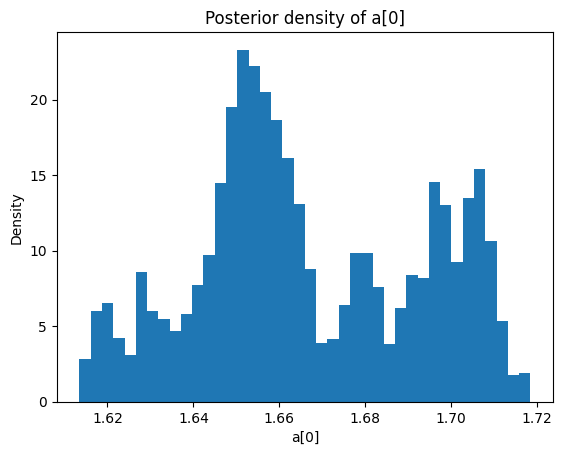

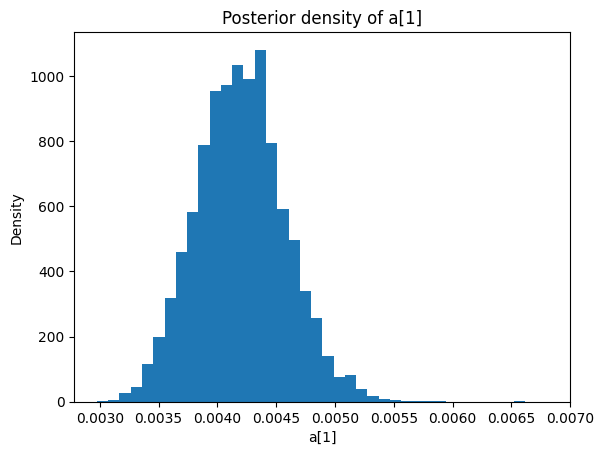

In [7]:
# Fonction pour calculer la densité a posteriori p(x | data)
def posterior_density(x, data):
    """
    Calculate the posterior density p(x | data).

    Parameters:
    - x (array): Parameter vector.
    - data (tuple): Tuple containing data for both prey and predator populations.

    Returns:
    - float: Posterior density.
    """
    data_proie, data_predateur = data
    solution_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt)
    sigma_carré_proie = np.mean((data_proie - solution_opt.y[0])**2)
    sigma_carré_predateur = np.mean((data_predateur - solution_opt.y[1])**2)

    p_prior = np.prod(1/x * 1 / (np.sqrt(2*np.pi)*params['zeta'])* np.exp(-1/(2*params['zeta']**2) * (np.log(x) - np.log(params['lambda']))**2))
    solution_data = solution(0, 8, x[6], x[7], x[:6]) 

    e_proie = np.sum((data_proie - solution_data.y[0])**2)
    e_predateur = np.sum((data_predateur - solution_data.y[1])**2)
    p_likelihood_proie = 1/(2*np.pi*sigma_carré_proie)**(len(data_proie)/2) * np.exp(-1/(2*sigma_carré_proie) * e_proie)
    p_likelihood_predateur = 1/(2*np.pi*sigma_carré_predateur)**(len(data_predateur)/2) * np.exp(-1/(2*sigma_carré_predateur) * e_predateur)
    p_likelihood = p_likelihood_proie * p_likelihood_predateur

    return p_prior * p_likelihood

# Paramètres de l'algorithme
num_iterations = 30000
burn_in = 1000 # Nombre d'itérations à brûler avant de collecter des échantillons
data = (data_proie, data_predateur)

# Initialisation
x = best_result
current_x = x
samples = []

# Boucle d'itérations
for t in range(num_iterations):
    # Proposez une nouvelle valeur
    proposed_x = np.random.normal(current_x, scale=0.001)

    # Density of the normal distribution with mean current_x and standard deviation 0.001
    prior_proposed_x = np.prod((np.sqrt(2*np.pi)*0.001)* np.exp(-1/(2*0.001**2) * (proposed_x - current_x)**2))

    # Density of the distribution of current_x with mean proposed_x and standard deviation 0.001
    prior_x = np.prod((np.sqrt(2*np.pi)*0.001)* np.exp(-1/(2*0.001**2) * (current_x - proposed_x)**2))

    # Calculez la probabilité d'acceptation
    alpha = min(1, posterior_density(proposed_x, data) * prior_proposed_x /
                         (posterior_density(current_x, data) * prior_x) )

    # Acceptez la proposition avec probabilité alpha
    if np.random.rand() < alpha:
        current_x = proposed_x

    # Collectez des échantillons après la période de brûlure
    if t > burn_in:
        samples.append(current_x)

# Afficher la loi de la première coordonnée de x (a[0])
samples = np.array(samples)
plt.hist(samples[:, 0], bins=40, density=True)
plt.xlabel('a[0]')
plt.ylabel('Density')
plt.title('Posterior density of a[0]')
plt.show()

# Afficher la loi de la première coordonnée de x (a[1])
samples = np.array(samples)
plt.hist(samples[:, 1], bins=40, density=True)
plt.xlabel('a[1]')
plt.ylabel('Density')
plt.title('Posterior density of a[1]')
plt.show()


Question 6.

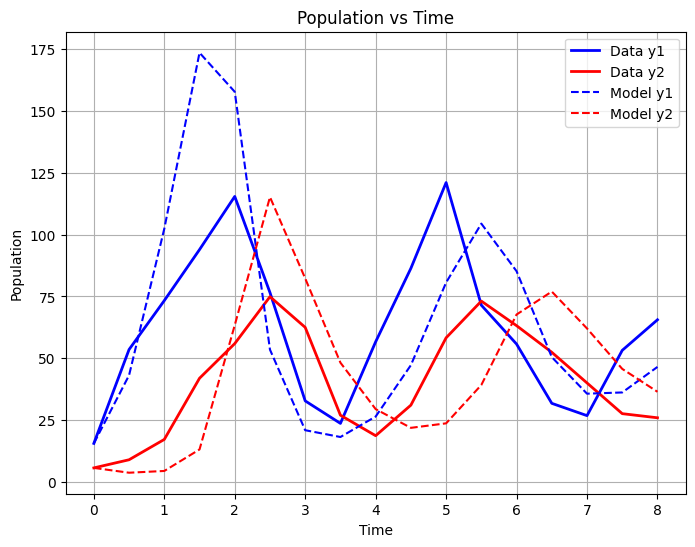

In [9]:
# Function to calculate the loss function for optimization
def E_bis(a, x, y):
    """
    Calculate the loss function for optimization.

    Parameters:
    - a (array): Parameter vector.
    - x (array): Data for prey population.
    - y (array): Data for predator population.

    Returns:
    - float: Loss value.
    """
    loss = 0
    time = np.linspace(0, 8, len(x))
    for t in range(len(x)-1):
        M = solution(time[t], time[t+1], x[t], y[t], a, n_step=2)
        M_proie = M.y[0][1]
        M_predateur = M.y[1][1]
        e_proie = np.log(np.abs(M_proie)) - np.log(x[t+1])
        e_predateur = np.log(np.abs(M_predateur)) - np.log(y[t+1])
        
        loss += e_proie**2 + e_predateur**2

    return np.clip(loss, 0, 1e5)


# Sample from the prior distribution
num_samples = 3
initial_guesses = []
cube = [(params['lambda'][i] * np.exp(-2 * params['zeta']), params['lambda'][i] * np.exp(2 * params['zeta'])) for i in range(8)]
for _ in range(num_samples):
    x = np.clip(np.random.lognormal(np.log(params['lambda']), params['zeta']), [c[0] for c in cube], [c[1] for c in cube])
    initial_guesses.append(x)

results = []

for initial_guess in initial_guesses:
    result = minimize(lambda p: E_bis(p[:6], data_proie, data_predateur), initial_guess, method='Powell', bounds=cube)
    a_opt = result.x[:6]
    results.append(a_opt)

best_result = min(results, key=lambda r: E_bis(r[:6], data_proie, data_predateur))
a_opt = best_result[:6]
y0_opt = (data_proie[0], data_predateur[0])

# Plot the data and the optimized model
M_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt)
t_opt = M_opt.t
y1_opt = M_opt.y[0]
y2_opt = M_opt.y[1]

time = np.linspace(0, 8, len(data_proie))
plt.figure(figsize=(8, 6))
plt.plot(time, data_proie, label='Data y1', color='blue', linewidth=2)
plt.plot(time, data_predateur, label='Data y2', color='red', linewidth=2)
plt.plot(t_opt, y1_opt, label='Model y1', color='blue', linestyle='dashed')
plt.plot(t_opt, y2_opt, label='Model y2', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population vs Time')
plt.grid(True)
plt.legend()
plt.show()


/var/folders/21/y9qxt5655msd8zr23lpd27_00000gn/T/ipykernel_3568/1354506819.py:23: RuntimeWarning: invalid value encountered in log
  p_prior = np.prod(1/x * 1 / (np.sqrt(2*np.pi)*params['zeta'])* np.exp(-1/(2*params['zeta']**2) * (np.log(x) - np.log(params['lambda'])[:6])**2))


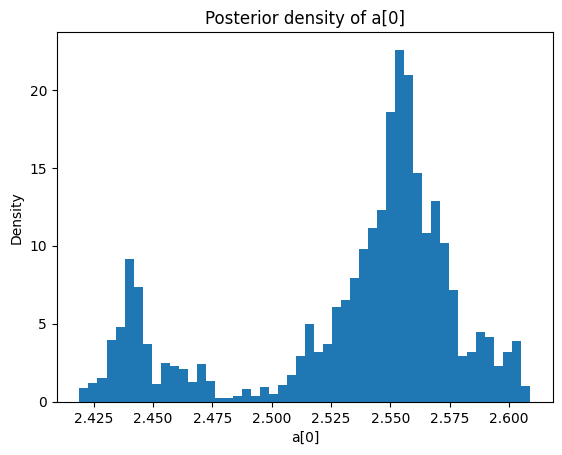

In [10]:
# Fonction pour calculer la densité a posteriori p(x | data)
def posterior_density(x, data):
    """
    Calculate the posterior density p(x | data).

    Parameters:
    - x (array): Parameter vector.
    - data (tuple): Tuple containing data for both prey and predator populations.

    Returns:
    - float: Posterior density.
    """
    data_proie, data_predateur = data
    
    # Calculate the optimal solution based on current parameter values
    solution_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt)
    
    # Calculate the variance of the differences between data and model predictions
    sigma_carré_proie = np.mean((data_proie - solution_opt.y[0])**2)
    sigma_carré_predateur = np.mean((data_predateur - solution_opt.y[1])**2)

    # Calculate the prior probability
    p_prior = np.prod(1/x * 1 / (np.sqrt(2*np.pi)*params['zeta'])* np.exp(-1/(2*params['zeta']**2) * (np.log(x) - np.log(params['lambda'])[:6])**2))
    
    # Calculate the likelihood for prey and predator populations
    time = np.linspace(0, 8, len(data_proie))
    loss_proie = 0
    loss_predateur = 0
    
    for t in range(len(data_proie)-1):
        M = solution(time[t], time[t+1], data_proie[t], data_predateur[t], a)
        M_proie = M.y[0][0]
        M_predateur = M.y[1][0]
        e_proie = np.log(M_proie) - np.log(data_proie[t+1])
        e_predateur = np.log(M_predateur) - np.log(data_predateur[t+1])

        loss_proie += e_proie**2
        loss_predateur += e_predateur**2

    p_likelihood_proie = 1/(2*np.pi*sigma_carré_proie)**(len(data_proie)/2) * np.exp(-1/(2*sigma_carré_proie) * e_proie)
    p_likelihood_predateur = 1/(2*np.pi*sigma_carré_predateur)**(len(data_predateur)/2) * np.exp(-1/(2*sigma_carré_predateur) * np.sum(e_predateur))
    p_likelihood = p_likelihood_proie * p_likelihood_predateur
    
    return p_prior * p_likelihood

# Paramètres de l'algorithme
num_iterations = 10000
burn_in = 1000  # Nombre d'itérations à brûler avant de collecter des échantillons
data = (data_proie, data_predateur)
# Initialisation
x = best_result
current_x = x
samples = []

# Boucle d'itérations
for t in range(num_iterations):
    # Proposez une nouvelle valeur
    proposed_x = np.random.normal(current_x, scale=0.001)

    # Calculez la probabilité d'acceptation
    alpha = min(1, posterior_density(proposed_x, data) / posterior_density(current_x, data))

    # Acceptez la proposition avec probabilité alpha
    if np.random.rand() < alpha:
        current_x = proposed_x

    # Collectez des échantillons après la période de brûlure
    if t > burn_in:
        samples.append(current_x)

# Afficher la loi de la première coordonnée de x (a[0])
samples = np.array(samples)

plt.hist(samples[:, 0], bins=50, density=True)
plt.xlabel('a[0]')
plt.ylabel('Density')
plt.title('Posterior density of a[0]')
plt.show()


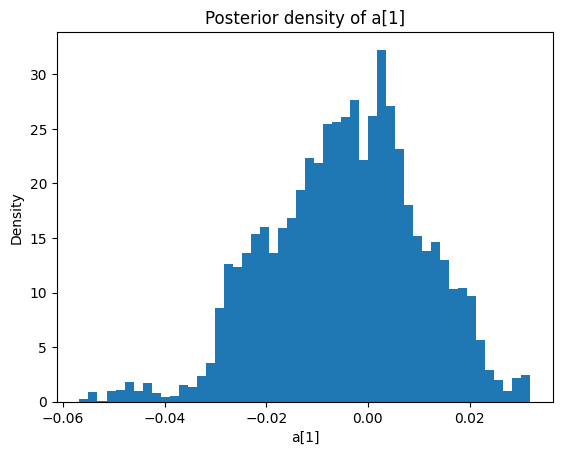

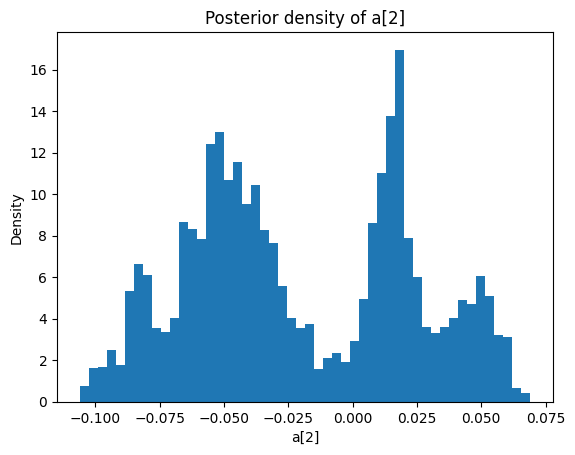

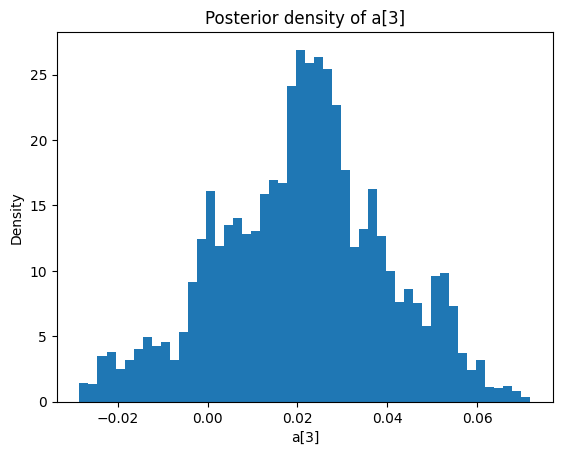

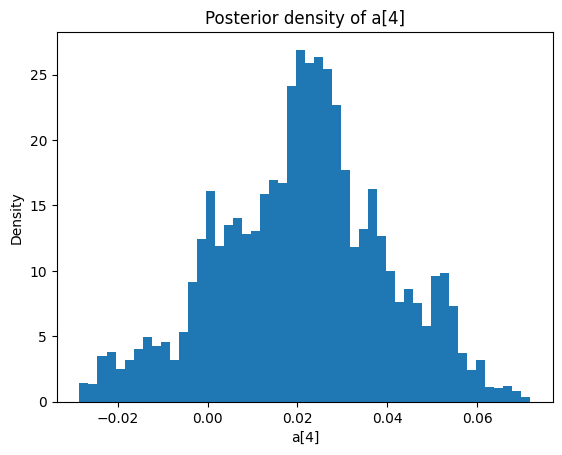

In [11]:
plt.hist(samples[:, 1], bins=50, density=True)
plt.xlabel('a[1]')
plt.ylabel('Density')
plt.title('Posterior density of a[1]')
plt.show()

plt.hist(samples[:, 2], bins=50, density=True)
plt.xlabel('a[2]')
plt.ylabel('Density')
plt.title('Posterior density of a[2]')
plt.show()

plt.hist(samples[:, 3], bins=50, density=True)
plt.xlabel('a[3]')
plt.ylabel('Density')
plt.title('Posterior density of a[3]')
plt.show()

plt.hist(samples[:, 3], bins=50, density=True)
plt.xlabel('a[4]')
plt.ylabel('Density')
plt.title('Posterior density of a[4]')
plt.show()


Question 7.

/Users/dariusdabert/Library/Python/3.10/lib/python/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


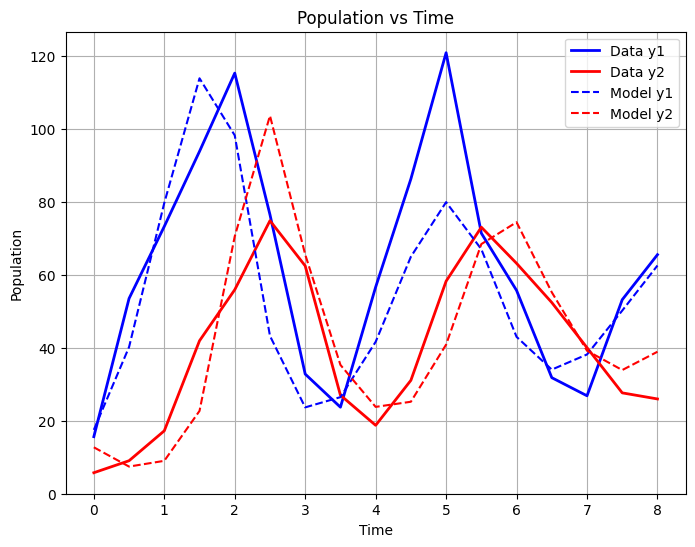

In [12]:
# Function to compute the error between model and data
def E(a, y0, m, data_y1, data_y2):
    """
    Compute the error between model and data.

    Parameters:
    - a: Model parameters for the system of differential equations (length 6)
    - y0: Initial conditions for the system of differential equations (length 2)
    - data_y1: Observed data for the first population
    - data_y2: Observed data for the second population

    Returns:
    - Error value
    """
    M = solution(0, 8, y0[0], y0[1], a, m = round(m))
    M_proie = M.y[0]
    M_predateur = M.y[1]
    e_proie = np.log(np.abs(M_proie)) - np.log(data_y1)
    e_predateur = np.log(np.abs(M_predateur)) - np.log(data_y2)
    return np.clip(np.sum(e_proie**2 + e_predateur**2), 0, 1e5)

# Sample from the prior distribution
num_samples = 4
initial_guesses = []
cube = [(params['lambda'][i] * np.exp(-2 * params['zeta']), params['lambda'][i] * np.exp(2 * params['zeta'])) for i in range(8)] 
for _ in range(num_samples):
    x = np.clip(np.random.lognormal(np.log(params['lambda']), params['zeta']), [c[0] for c in cube], [c[1] for c in cube])
    m = np.random.binomial(1, 1/2)
    initial_guesses.append(np.concatenate((x, [m])))

cube += [(-0.2,1.2)]
results = []

# Optimize model parameters using Nelder-Mead algorithm
for initial_guess in initial_guesses:
    result = minimize(lambda p: E(p[:6], p[6:8], p[8], data_proie, data_predateur), initial_guess, method='SLSQP', bounds=cube)
    results.append(result.x)

# Select the best result based on the minimum error
best_result = min(results, key=lambda r: E(r[:6], r[6:8], r[8], data_proie, data_predateur))
a_opt = best_result[:6]
y0_opt = best_result[6:8]
m_opt = round(best_result[8])


# Plot the data and the optimized model
M_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt, m = m_opt)
t_opt = M_opt.t
y1_opt = M_opt.y[0]
y2_opt = M_opt.y[1]

plt.figure(figsize=(8, 6))
plt.plot(t_opt, data_proie, label='Data y1', color='blue', linewidth=2)
plt.plot(t_opt, data_predateur, label='Data y2', color='red', linewidth=2)
plt.plot(t_opt, y1_opt, label='Model y1', color='blue', linestyle='dashed')
plt.plot(t_opt, y2_opt, label='Model y2', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population vs Time')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
m_opt

0

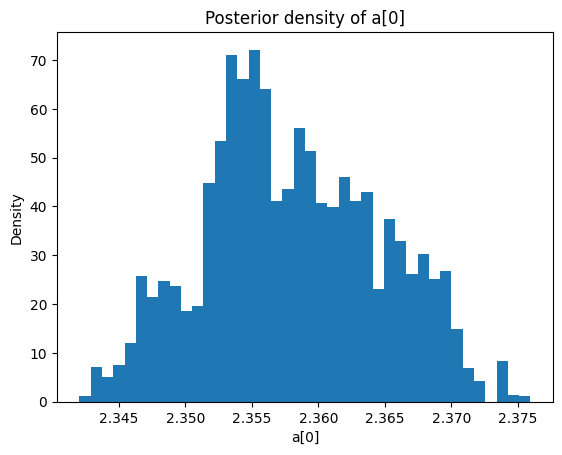

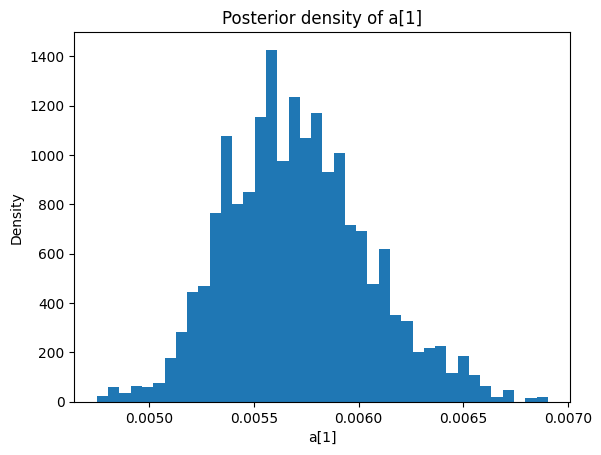

In [14]:
# Fonction pour calculer la densité a posteriori p(x | data)
def posterior_density(x, m, data):
    """
    Calculate the posterior density p(x | data).

    Parameters:
    - x (array): Parameter vector.
    - data (tuple): Tuple containing data for both prey and predator populations.

    Returns:
    - float: Posterior density.
    """
    data_proie, data_predateur = data
    solution_opt = solution(0, 8, y0_opt[0], y0_opt[1], a_opt, m = round(m))
    sigma_carré_proie = np.mean((data_proie - solution_opt.y[0])**2)
    sigma_carré_predateur = np.mean((data_predateur - solution_opt.y[1])**2)

    p_prior = np.prod(1/x * 1 / (np.sqrt(2*np.pi)*params['zeta'])* np.exp(-1/(2*params['zeta']**2) * (np.log(x) - np.log(params['lambda']))**2))
    solution_data = solution(0, 8, x[6], x[7], x[:6]) 

    e_proie = np.sum((data_proie - solution_data.y[0])**2)
    e_predateur = np.sum((data_predateur - solution_data.y[1])**2)
    p_likelihood_proie = 1/(2*np.pi*sigma_carré_proie)**(len(data_proie)/2) * np.exp(-1/(2*sigma_carré_proie) * e_proie)
    p_likelihood_predateur = 1/(2*np.pi*sigma_carré_predateur)**(len(data_predateur)/2) * np.exp(-1/(2*sigma_carré_predateur) * e_predateur)
    p_likelihood = p_likelihood_proie * p_likelihood_predateur

    return p_prior * p_likelihood

# Paramètres de l'algorithme
num_iterations = 10000
burn_in = 1000 # Nombre d'itérations à brûler avant de collecter des échantillons
data = (data_proie, data_predateur)

# Initialisation
x = best_result
current_x = x[:8]
current_m = 0
samples = []
samples_m = []

# Boucle d'itérations
for t in range(num_iterations):
    # Proposez une nouvelle valeur
    proposed_x = np.random.normal(current_x, scale=0.001)
    proposed_m = np.random.binomial(1, 1/2)

    # Density of the normal distribution with mean current_x and standard deviation 0.001
    prior_proposed_x = np.prod((np.sqrt(2*np.pi)*0.001)* np.exp(-1/(2*0.001**2) * (proposed_x - current_x)**2))

    # Density of the distribution of current_x with mean proposed_x and standard deviation 0.001
    prior_x = np.prod((np.sqrt(2*np.pi)*0.001)* np.exp(-1/(2*0.001**2) * (current_x - proposed_x)**2))

    # Calculez la probabilité d'acceptation
    alpha = min(1, posterior_density(proposed_x, proposed_m, data) * prior_proposed_x /
                         (posterior_density(current_x, current_m, data) * prior_x) )

    # Acceptez la proposition avec probabilité alpha
    if np.random.rand() < alpha:
        current_x = proposed_x
        current_m = proposed_m

    # Collectez des échantillons après la période de brûlure
    if t > burn_in:
        samples.append(current_x)
        samples_m.append(current_m)


# Afficher la loi de la première coordonnée de x (a[0])
samples = np.array(samples)
plt.hist(samples[:, 0], bins=40, density=True)
plt.xlabel('a[0]')
plt.ylabel('Density')
plt.title('Posterior density of a[0]')
plt.show()

# Afficher la loi de la première coordonnée de x (a[1])
samples = np.array(samples)
plt.hist(samples[:, 1], bins=40, density=True)
plt.xlabel('a[1]')
plt.ylabel('Density')
plt.title('Posterior density of a[1]')
plt.show()


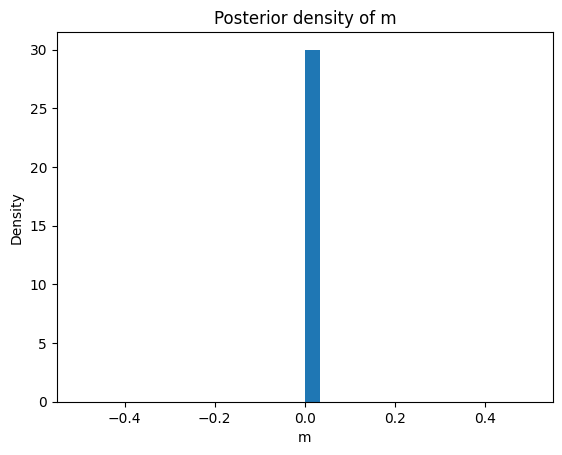

In [15]:
# Afficher la loi de la première coordonnée de x (a[1])
samples_m = np.array(samples_m)
plt.hist(samples_m, bins=30, density=True)
plt.xlabel('m')
plt.ylabel('Density')
plt.title('Posterior density of m')
plt.show()